_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

# Coding Lab 1

- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-04-26 10:32:31W. Europe Daylight Time

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

sklearn: 1.4.2

numpy     : 1.26.4
scipy     : 1.13.0
pandas    : 2.2.1
matplotlib: 3.8.4

Watermark: 2.4.3



In [2]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [4]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [5]:
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """

    y = x.apply(
        lambda col: signal.sosfiltfilt(  # apply the filter to all columns
            signal.butter(  # apply the filter to a column
                order,  # TODO tweak order value (try 6 and 9) -> could not see any difference
                [low / (fs / 2), high / (fs / 2)],  # frequency thresholds (normalized)
                btype="band",  # filter type
                analog=False,
                output="sos",  # second-order sections
            ),
            col,
        )
    )

    return y

In [44]:
xf = filter_signal(x, fs, 300, 1000, order=3)
# Passband threshold source: https://www.researchgate.net/figure/Representation-of-spikes-in-the-300-1-000Hz-band-a-Frequency-spectrum-of-two-averaged_fig1_343243015
# 300-6000 could also be used: https://www.fieldtriptoolbox.org/tutorial/spike/

In [45]:
print(x.head())
print(xf.head())

   Ch1  Ch2  Ch3  Ch4
0 -141 -184 -316 -191
1 -136 -167 -290 -196
2 -168 -185 -306 -219
3 -147 -188 -332 -219
4 -165 -196 -331 -206
         Ch1       Ch2       Ch3        Ch4
0  -4.300009 -4.940764 -4.799721  -6.285654
1  -8.282519 -5.830786 -4.998896  -9.024715
2 -12.262485 -6.769211 -5.313780 -11.813176
3 -16.125633 -7.722314 -5.720602 -14.573452
4 -19.762314 -8.654018 -6.191376 -17.227634


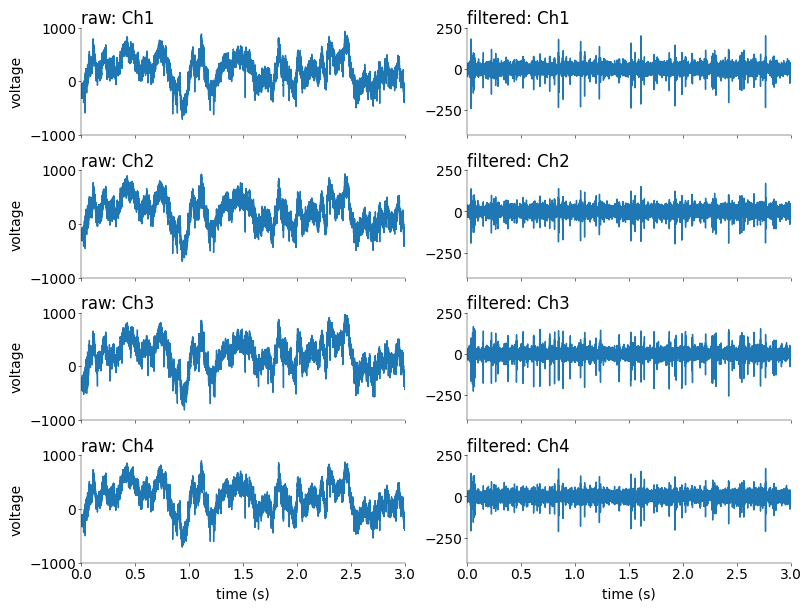

In [46]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -----------------------------------------------------------------
# Plot raw and filtered signal segments for all 4 channels (0.5 pt)
# -----------------------------------------------------------------

for i, m in enumerate(mosaic):
    raw = m[0]
    filtered = m[1]

    # plot colum i of the raw signal
    ax[raw].plot(x.index * dt, x.iloc[:, i])

    # plot column i of the filtered signal
    ax[filtered].plot(x.index * dt, xf.iloc[:, i])

    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))  # (1.0515, 1.0535)
    ax[filtered].set_ylim((-400, 250))

    ax[raw].set_ylabel("voltage")
    ax[filtered].set_title(m[1], loc="left")

    ax[raw].set_title(m[0], loc="left")

    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. **Plot the threshold**. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

In [47]:
def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: int = 10
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes, in this case, the relative local minima of the signal x.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: int
        a window of 'refactory period', within which there's only one spike.
        Default is 10 but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the singal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    Use scipy functions to detect local minima.
    Noted that there are four channels in signal x.

    """
    # TODO compute and apply threshold per channel
    # # compute the robust standard deviation per channel
    # sigma_hat = np.apply_along_axis(
    #     lambda col: np.median(np.abs(col - np.mean(col))) / 0.6745, axis=0, arr=x
    # )
    # print(
    #     "robust standard deviations: Ch1 = {}; Ch2 = {}; Ch3 = {}; Ch4 = {}".format(
    #         *sigma_hat
    #     )
    # )
    # threshold = -N * sigma_hat
    # print("thresholds: Ch1 = {}; Ch2 = {}; Ch3 = {}; Ch4 = {}".format(*threshold))

    # -----------------------------------------------------------------------
    # compute the robust s.d. (0.5 pts) and calculate the threshold (0.5 pts)
    # -----------------------------------------------------------------------

    # robust standard deviation of all data
    sigma_hat = np.median(np.abs(x - np.mean(x))) / 0.6745
    print("robust standard deviation: {}".format(sigma_hat))

    # threshold
    threshold = -N * sigma_hat
    print("threshold: {}".format(threshold))

    # apply threshold: set all values over threshold to threshold
    x[x > threshold] = threshold

    # -----------------------------------------------------------------------
    # find all local minima (1.5 pts)
    # -----------------------------------------------------------------------

    # get local minima per channel
    local_minima = signal.argrelmin(
        x, axis=0, order=lockout, mode="clip"  # TODO tweak lockout  # TODO try wrap
    )
    # local_minima has format ([row_indices], [col_indices])

    # zip local_minima to an array of tuples
    s = list(zip(*local_minima))  # TODO shape is not like expected in the docstring

    # get the time of the spikes
    unique_indices = np.unique(local_minima[0])
    t = unique_indices  # / fs  # TODO as t in ms is not used so far, t will be just the index
    print(t)
    print(type(t))

    return s, t, threshold


s, t, threshold = detect_spikes(xf.to_numpy(), fs)  # TODO why do i need t?

robust standard deviation: 24.051116722061348
threshold: -120.25558361030674
[    1124     1125     1541 ... 19199626 19199627 19199628]
<class 'numpy.ndarray'>


In [67]:
def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: int = 10
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes, in this case, the relative local minima of the signal x.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: int
        a window of 'refactory period', within which there's only one spike.
        Default is 10 but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the singal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    Use scipy functions to detect local minima.
    Noted that there are four channels in signal x.

    """

    # -----------------------------------------------------------------------
    # compute the robust s.d. (0.5 pts) and calculate the threshold (0.5 pts)
    # -----------------------------------------------------------------------
    # calaculate the robust standard deviation for each channel (column)
    sigma_hat = np.apply_along_axis(
        lambda col: np.median(np.abs(col - np.mean(col))) / 0.6745, axis=0, arr=x
    )
    print("RSD: Ch1 = {}; Ch2 = {}; Ch3 = {}; Ch4 = {}".format(*sigma_hat))
    # calculate the threshold for each channel
    threshold = -N * sigma_hat
    print("Threshold: Ch1 = {}; Ch2 = {}; Ch3 = {}; Ch4 = {}".format(*threshold))

    # -----------------------------------------------------------------------
    # find all local minima (1.5 pts)
    # -----------------------------------------------------------------------

    spike_indices = []

    for i in range(x.shape[1]):  # iterate through each channel
        channel_minima = signal.argrelmin(x[:, i])[0]  # find local minima
        valid_spikes = channel_minima[x[channel_minima, i] < threshold[i]]

        # Enforce lockout period to prevent multiple detections within a small interval
        if valid_spikes.size > 0:
            final_spikes = [valid_spikes[0]]
            for spike in valid_spikes[1:]:
                if spike - final_spikes[-1] > lockout:
                    final_spikes.append(spike)

            # Append with channel information
            spike_indices.extend([(spike, i) for spike in final_spikes])

    # Convert spike indices to array for uniform output type
    s = np.array(spike_indices, dtype="object")  # Array of tuples
    t = np.array(
        [index[0] / fs * 1000 for index in spike_indices]
    )  # Convert indices to times in ms

    return s, t, threshold


s, t, threshold = detect_spikes(xf.to_numpy(), fs)  # TODO why do i need t?

RSD: Ch1 = 0.5696773300191017; Ch2 = 0.34428779744578775; Ch3 = 0.7818837742689787; Ch4 = 0.3765586023060692
Threshold: Ch1 = -2.8483866500955086; Ch2 = -1.7214389872289386; Ch3 = -3.9094188713448936; Ch4 = -1.882793011530346


In [73]:
threshold

array([-2.84838665, -1.72143899, -3.90941887, -1.88279301])

In [72]:
np.array([row[0] for row in s if row[1] == 2])

array([    1125,     1541,     1770, ..., 19196212, 19197387, 19199626],
      dtype=int64)

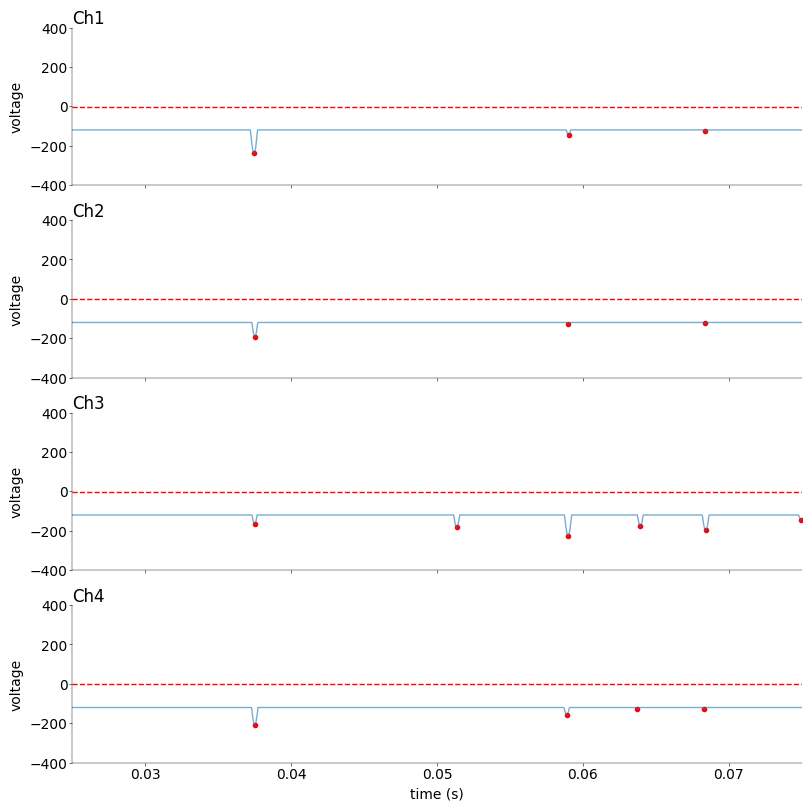

In [74]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# --------------------------------------------
# plot threshold and detected spikes (0.5 pts)
# --------------------------------------------

for i, col in enumerate(cols):

    # extract all row indices (first value) of s with column index i (second value)
    spike_indices = np.array([row[0] for row in s if row[1] == i])

    # plot signal
    ax[col].plot(x.index * dt, xf.iloc[:, i], alpha=0.6)

    # plot xf value as point at spike index
    ax[col].scatter(
        spike_indices / fs, xf.iloc[spike_indices, i], color="r", label="spike"
    )

    # plot threshold as horizontal line
    ax[col].axhline(y=threshold[i], color="r", linestyle="--", label="threshold")

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage")

    ax[col].set_title(col, loc="left")

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [65]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times othrdf the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """

    # insert your code here

    # ------------------------------
    # extract spike waveforms (1 pt)
    # ------------------------------

    # for each index i in s extract the values x[i-10:i+20, :] and store them in w using broadcasting.
    w = np.array([x[i - 10 : i + 20, :] for i in s])
    print("w.shape: {}".format(w.shape))

    return w


waveforms = extract_waveforms(
    xf.to_numpy(), t
)  # TODO t must have indices here, not ms. If t is changed, something must be done to s as well, to replace t by s and make this work again...

w.shape: (34118, 30, 4)


Plot first 100 spike waveforms

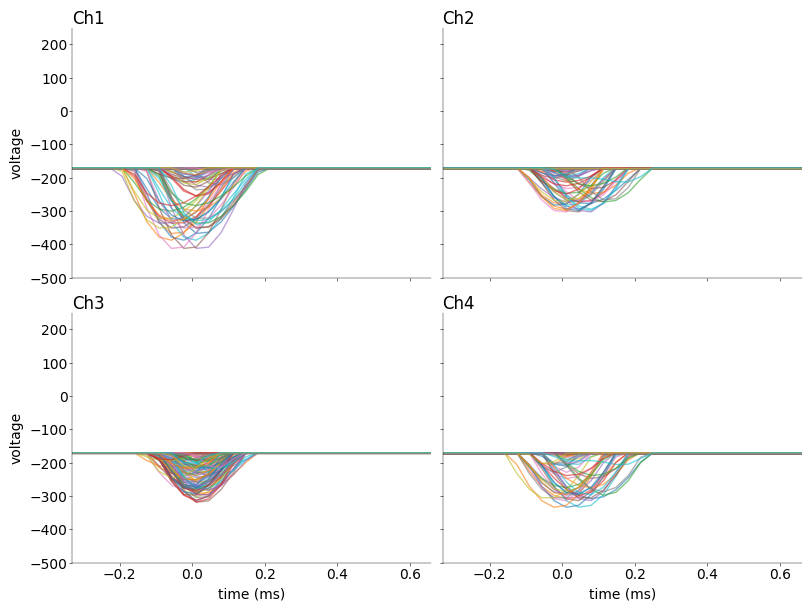

In [66]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------
# plot first 100 spikes (0.5 pts)
# -------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    # plot 100 times the 30 samples from channel i -> waveforms[:100, :, i]
    for j in range(100):  # TODO for-loop is ugly
        ax[col].plot(np.linspace(-0.33, 0.66, 30), waveforms[j, :, i], alpha=0.6)

    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

Plot largest 100 spike waveforms

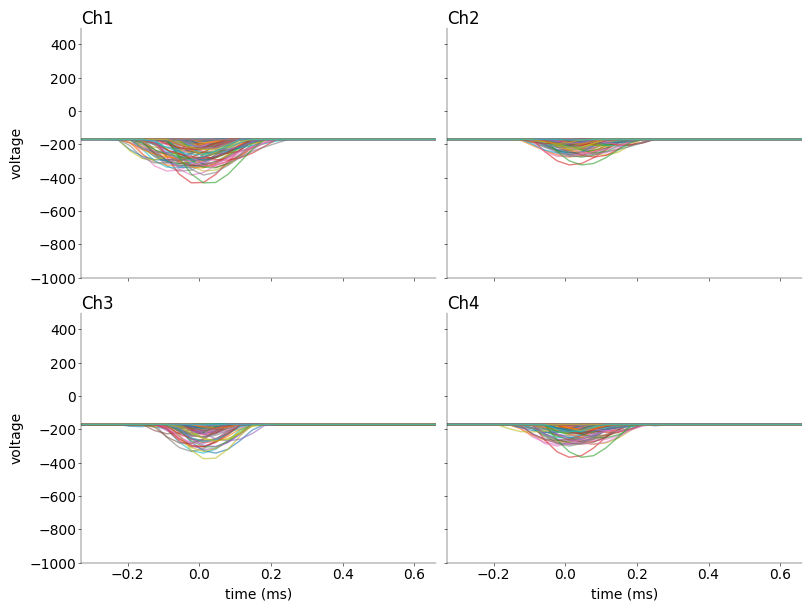

In [67]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------------
# plot the largest 100 spikes (0.5 pts)
# -------------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):

    # extract the 100 largest spikes from channel i
    # this returns the indices of the 100 largest spikes
    largest_spikes = np.argsort(np.max(waveforms[:, :, i], axis=1))[-100:]

    for j in largest_spikes:  # TODO for loop is ugly
        ax[col].plot(np.linspace(-0.33, 0.66, 30), waveforms[j, :, i], alpha=0.6)

    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage")
    else:
        ax[col].set_yticklabels([])

# TODO Something is wrong with the waveforms?!

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()``` (2 pts). You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


### PCA:
- how to preprocess data?


(https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca)

In [68]:
def extract_features(w: np.ndarray):
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # insert your code here

    # ---------------------------------------------
    # obtain first 3 principle components (2 pts)
    # ---------------------------------------------
    pca = PCA(
        n_components=3
    )  # TODO somehow prefiltering the data? is this even necessary?
    b = np.concatenate(
        [pca.fit_transform(w[:, :, i]) for i in range(w.shape[2])], axis=1
    )
    print("b.shape: {}".format(b.shape))
    # print("b[5]: {}".format(b[5]))

    # -----------------------------------------------------
    # Print the fraction of variance explained (1 pt)
    # -----------------------------------------------------
    print(
        "explained variance: {}".format(pca.explained_variance_)
    )  # TODO is this correct? might be too large numbers

    return b


features = extract_features(waveforms)

b.shape: (34118, 12)
explained variance: [10686.86061342  1876.77841446   398.82380043]


Text(0.5, 0.98, 'Pairwise 1st PCs')

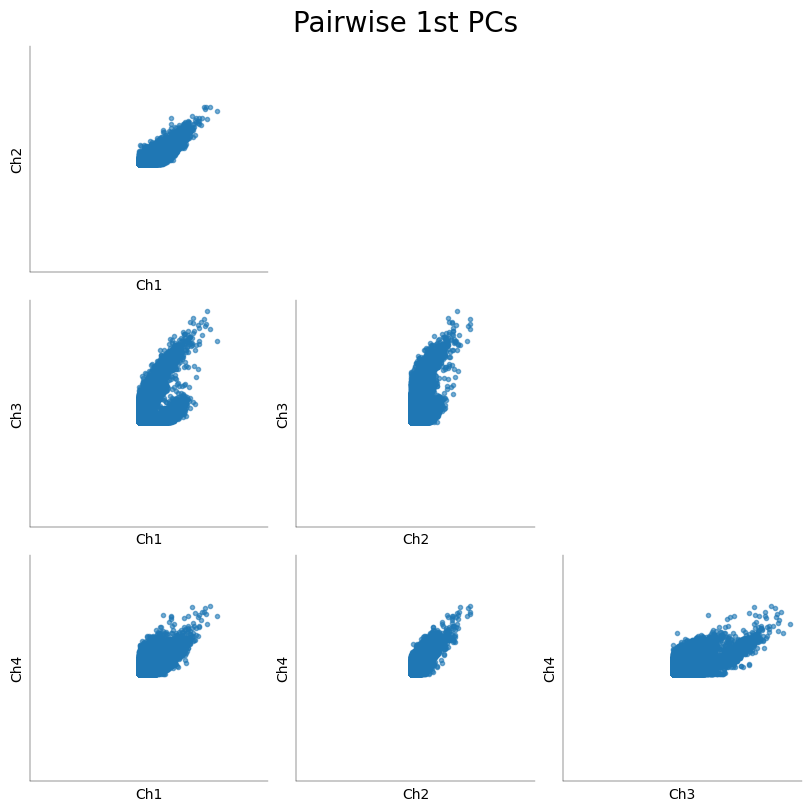

In [69]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    y, x = m.split(" vs ")

    # plot the 1st PC of channel y against the 1st PC of channel x
    ax[m].scatter(features[:, i[x]], features[:, i[y]], alpha=0.6)

    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)
    ax[m].set_xlim((-1500, 1500))
    ax[m].set_ylim((-1500, 1500))
    ax[m].set_xticks([])
    ax[m].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [ ]:
# # save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)